# Calibrating models to data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-case-data" data-toc-modified-id="Load-case-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load case data</a></span></li><li><span><a href="#Running-parameter-sampling" data-toc-modified-id="Running-parameter-sampling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Running parameter sampling</a></span><ul class="toc-item"><li><span><a href="#Specify-which-model-parameters-to-sample-over" data-toc-modified-id="Specify-which-model-parameters-to-sample-over-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Specify which model parameters to sample over</a></span></li><li><span><a href="#Specify-which-model-parameters-to-hold-constant." data-toc-modified-id="Specify-which-model-parameters-to-hold-constant.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Specify which model parameters to hold constant.</a></span></li><li><span><a href="#Choose-how-to-penalize-a-model-when-it-doesn't-agree-with-the-data" data-toc-modified-id="Choose-how-to-penalize-a-model-when-it-doesn't-agree-with-the-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Choose how to penalize a model when it doesn't agree with the data</a></span></li><li><span><a href="#Generate-the-sampler-object" data-toc-modified-id="Generate-the-sampler-object-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Generate the sampler object</a></span></li></ul></li><li><span><a href="#Explore-the-posterior-distribution" data-toc-modified-id="Explore-the-posterior-distribution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore the posterior distribution</a></span><ul class="toc-item"><li><span><a href="#Compare-highest-likelihood-model-trajectory-with-calibration-data" data-toc-modified-id="Compare-highest-likelihood-model-trajectory-with-calibration-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compare highest-likelihood model trajectory with calibration data</a></span></li></ul></li><li><span><a href="#Joint-posterior-probability-distribution" data-toc-modified-id="Joint-posterior-probability-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Joint posterior probability distribution</a></span></li></ul></div>

To begin with, we need to ensure `numpy` only uses one thread per processor.
The MCMC sampling routines by default use all cores (via [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html))
for parallelizing likelihood evaluations, and it's critical for performance that each process only use a single thread.
This must happen before `numpy` is imported, see [here](https://stackoverflow.com/questions/30791550/limit-number-of-threads-in-numpy).

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

## Load case data

In this example, we load public data from the [COVID Tracking Project](covidtracking.com) for Illinois.
Data is represented as `pandas.DataFrame`s.
`NaN` values are displayed when no data is available.
Note that `NaN`s tell the likelihood computation routines to skip a particular data point for evaluation.

In [2]:
from pydemic.data.united_states import covid_tracking
all_data = covid_tracking("Illinois")
all_data

,positive,negative,pending,hospitalized,hospitalized_cumulative,critical,in_icu_cumulative,on_ventilator_currently,on_ventilator_cumulative,recovered,...,hospitalized_increase,hash,commercial_score,negative_regular_score,negative_score,positive_score,score,grade,positive_incr,all_dead_incr
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,4.0,124.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,59126eb9417993e3d723a2036a8c55f4009b8c4a,0,0,0,0,0,NaN,NaN,NaN
2020-03-05,5.0,165.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,37e4191730f8125d012a6669374c431e1b992ea9,0,0,0,0,0,NaN,1.0,NaN
2020-03-06,5.0,180.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,378c0b1cc55d75dd8f784d13e1b92bb52ff6a99c,0,0,0,0,0,NaN,0.0,NaN
2020-03-07,6.0,191.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,763954898752eec4654e16ac457b3c53c2291b43,0,0,0,0,0,NaN,1.0,NaN
2020-03-08,6.0,191.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,f04f4a066b242ef392c84080656e7b334a819d11,0,0,0,0,0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30,118917.0,758188.0,NaN,3336.0,NaN,925.0,NaN,661.0,NaN,NaN,...,0,bd3df55e355d07fbca565bf597f0f6a06bf7b24f,0,0,0,0,0,NaN,1462.0,60.0
2020-05-31,120260.0,777999.0,NaN,3296.0,NaN,941.0,NaN,550.0,NaN,NaN,...,0,427a2b35d455008ed196bdf21f7928188f7f47ea,0,0,0,0,0,NaN,1343.0,60.0
2020-06-01,121234.0,797039.0,NaN,3215.0,NaN,902.0,NaN,547.0,NaN,NaN,...,0,3b2052a29a76ee793096ef6d47f9f6d11ab05a65,0,0,0,0,0,NaN,974.0,22.0


The SEIR++ model is defined as [SEIRPlusPlusSimulation](https://pydemic.readthedocs.io/en/latest/ref_models.html#pydemic.models.SEIRPlusPlusSimulation) in ```pydemic.models```, and outputs several healthcare system trackers. In this example, we'll calibrate on the number of occupied hospital (non-ICU) beds, the number of occupied ICU beds, and the total number of COVID-related deaths per day.

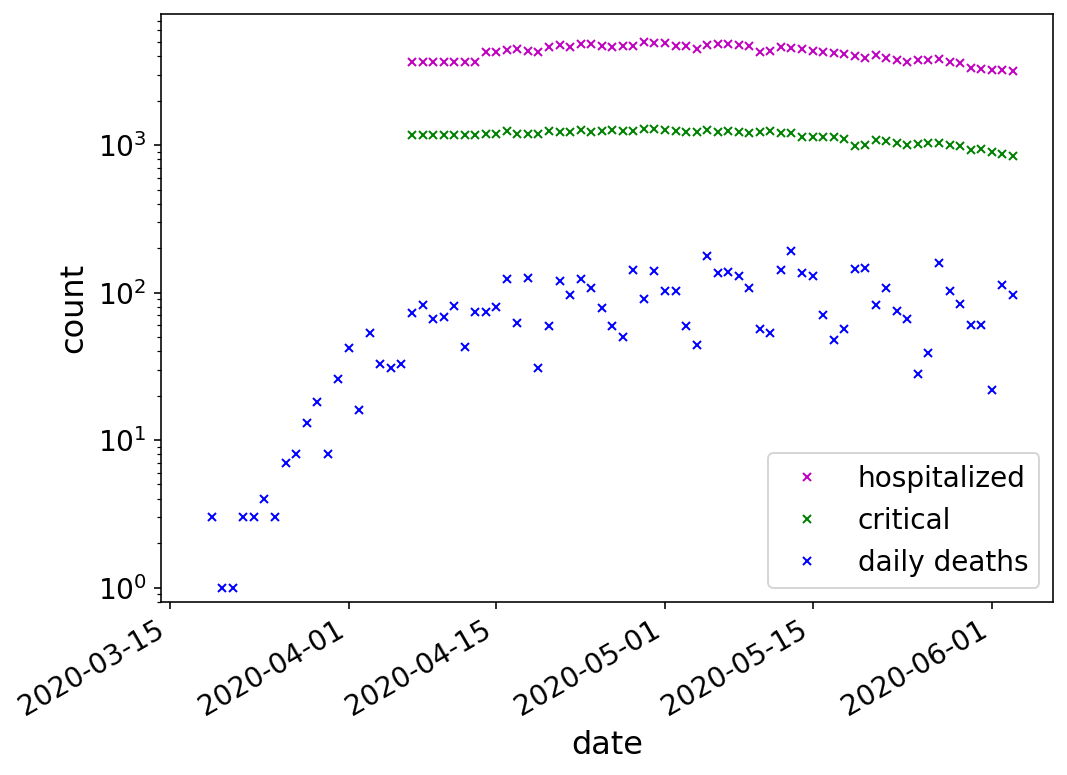

In [3]:
import matplotlib.pyplot as plt
data = all_data.loc[:, ['hospitalized', 'critical', 'all_dead_incr']]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(data.index, data.hospitalized, 'xm', ms=4, label='hospitalized')
ax.plot(data.index, data.critical, 'xg', ms=4, label='critical')
ax.plot(data.index, data.all_dead_incr, 'xb', ms=4, label='daily deaths')

ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)
fig.autofmt_xdate()

## Running parameter sampling

### Specify which model parameters to sample over

The model has many parameters, and we need to tell the calibration tool which ones to sample over.
We do this by defining a list of [SampleParameter](https://pydemic.readthedocs.io/en/latest/ref_sampling.html#pydemic.SampleParameter) objects.

In [4]:
from pydemic.sampling import SampleParameter
import numpy as np

sample_parameters = [
    SampleParameter('r0', (1, 5), 3, .2),
    SampleParameter('start_day', (35, 65)),
    SampleParameter('mitigation_t_0', (60, 85)),
    SampleParameter('mitigation_t_1', (70, 100)),
    SampleParameter('mitigation_factor_1', (.05, 1)),
    SampleParameter('log_ifr', (-6, -4), mean=np.log(.007), sigma=.175),
    SampleParameter('hospitalized_mean', (0.5, 40), mean=6.5, sigma=2.),
    SampleParameter('hospitalized_std', (0.5, 20), mean=4., sigma=2.),
    SampleParameter('discharged_mean', (0.5, 40), mean=6., sigma=2.),
    SampleParameter('discharged_std', (0.5, 20), mean=4., sigma=2.),
    SampleParameter('p_critical_prefactor', (0.05, 4.)),
    SampleParameter('critical_mean', (0.5, 10), mean=2., sigma=2.),
    SampleParameter('critical_std', (0.5, 10), mean=2., sigma=2.),
    SampleParameter('p_dead_prefactor', (0.05, 3.)),
    SampleParameter('dead_mean', (4, 20), mean=12, sigma=3),
    SampleParameter('dead_std', (1, 20), mean=8.5, sigma=3),
    SampleParameter('recovered_mean', (4, 20), mean=12.75, sigma=3),
    SampleParameter('recovered_std', (1, 20), mean=10, sigma=3),
    SampleParameter('all_dead_multiplier', (1, 10)),
    SampleParameter('all_dead_mean', (0, 10), mean=2, sigma=1),
    SampleParameter('all_dead_std', (0, 10), mean=2, sigma=1),
]

### Specify which model parameters to hold constant. 

In this example, we fix:
- the relative values of the severity model, i.e., the relative differences in severity as a function of age demographic
- the amplitude & time when seasonal forcing is strongest
- the properties of the delay distributions (assumed to be [gamma distributions](https://pydemic.readthedocs.io/en/latest/ref_models.html#pydemic.GammaDistribution))
for the serial interval and the incubation time
- the population of the simulation, including
   - the total number of individuals in the simulation
   - the demographic distribution of individuals (in this case, just an age distribution)
   - the initial number of infecious individuals (split across all demographics proportional to the distribution function above)
- the initial mitigation factor (which should probably be 1)

Since we're calibrating against Illinois data, we'll load the population of the state.

In [5]:
from pydemic.data.united_states import get_population, get_age_distribution
from pydemic.distributions import GammaDistribution

fixed_values = dict(
    p_symptomatic = np.array([0.057, 0.054, 0.294, 0.668, 0.614, 0.83 , 0.99 , 0.995, 0.999]),
    p_hospitalized = np.array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]),
    p_critical = np.array([0.05 , 0.05 , 0.05 , 0.05 , 0.063, 0.122, 0.274, 0.432, 0.709]),
    p_dead = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]),
    
    seasonal_forcing_amp = .1,
    peak_day = 15,
    
    serial_dist = GammaDistribution(mean=4, std=3.25),
    incubation_dist=GammaDistribution(5.5, 2),

    total_population = get_population("Illinois"),
    age_distribution = get_age_distribution(),
    initial_cases = 10,
    
    mitigation_factor_0 = 1.,
)

### Choose how to penalize a model when it doesn't agree with the data

We consider two instantaneous data streams and one raw increment data set, and we compare data to the model using a Poisson likelihood estimator.
To account for correlations in the first two data streams, we take the $T$'th route of the regular Poisson likelihood where $T$ is a guess for the data streams' correlation times.
We draw on the literature for these estimates and take $T_\mathrm{hospitalized} \sim 6$ and $T_\mathrm{critical} \sim 12.75$.

In [6]:
from pydemic.sampling import PoissonPowerNorm

hospitalized_norm = PoissonPowerNorm(1/6)
critical_norm = PoissonPowerNorm(1/12.75)

norms = {
    'all_dead_incr': 'poisson', 
    'critical': critical_norm,
    'hospitalized': hospitalized_norm
}

### Generate the sampler object

We first create a [LikelihoodEstimator](https://pydemic.readthedocs.io/en/latest/ref_sampling.html#pydemic.LikelihoodEstimator)
object and tell it about all of our parameters: which model parameters are fixed, which ones are sampled, the data to compare the model output against, the simulation class, and the norm that defines how to calculate the likelihood given a model output and data.

In [7]:
from pydemic import LikelihoodEstimator
from pydemic.models import SEIRPlusPlusSimulation

estimator = LikelihoodEstimator(
    simulator = SEIRPlusPlusSimulation,
    fixed_values = fixed_values, 
    sample_parameters = sample_parameters,
    data = data, 
    norms = norms
)

Run the sampler to get an estimate of the posterior probability distribution.
For `emcee`, you must speciy the number of steps to take and the number of walkers to use.
The number of walkers must be larger than the number of sample parameters.
We also use a custom set of moves.
See `emcee`'s [documentation](https://emcee.readthedocs.io/en/stable/).

In production code, the number of steps must be large, e.g., ```n_steps > 50000```.

Note that by default, [`LikelihoodEstimator.sample_emcee`](https://pydemic.readthedocs.io/en/latest/ref_sampling.html#pydemic.LikelihoodEstimator.sample_emcee)
uses all available cores.

In [8]:
n_steps = 1000
n_walkers = 512

import emcee.moves
moves = [
    (emcee.moves.KDEMove(), 0.4),
    (emcee.moves.DEMove(), 0.4),
    (emcee.moves.DESnookerMove(), 0.2)
]

np.seterr(invalid='ignore')
sampler = estimator.sample_emcee(n_steps, n_walkers, moves=moves)

100%|██████████| 1000/1000 [20:08<00:00,  1.21s/it]


## Explore the posterior distribution

The ```flat_chain``` object comprises a list of ```n_steps * n_walkers``` sets of proposed fit parameter values. The log likelihood of each proposed set is given by the ```flat_log_prob``` object.

Note that in general, one should thin these lists according to the autocorrelation time of the sampler. These details are beyond the scope of this example notebook. The ```emcee``` docs provide an introduction [here](https://emcee.readthedocs.io/en/stable/tutorials/line/) (see the text before the ```Results``` section) and [here](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/).

In [9]:
flat_chain = sampler.get_chain(flat=True)
flat_log_prob = sampler.get_log_prob(flat=True)

max_log_prob_index = np.argmax(flat_log_prob)
max_log_prob_values = flat_chain[max_log_prob_index]

### Compare highest-likelihood model trajectory with calibration data

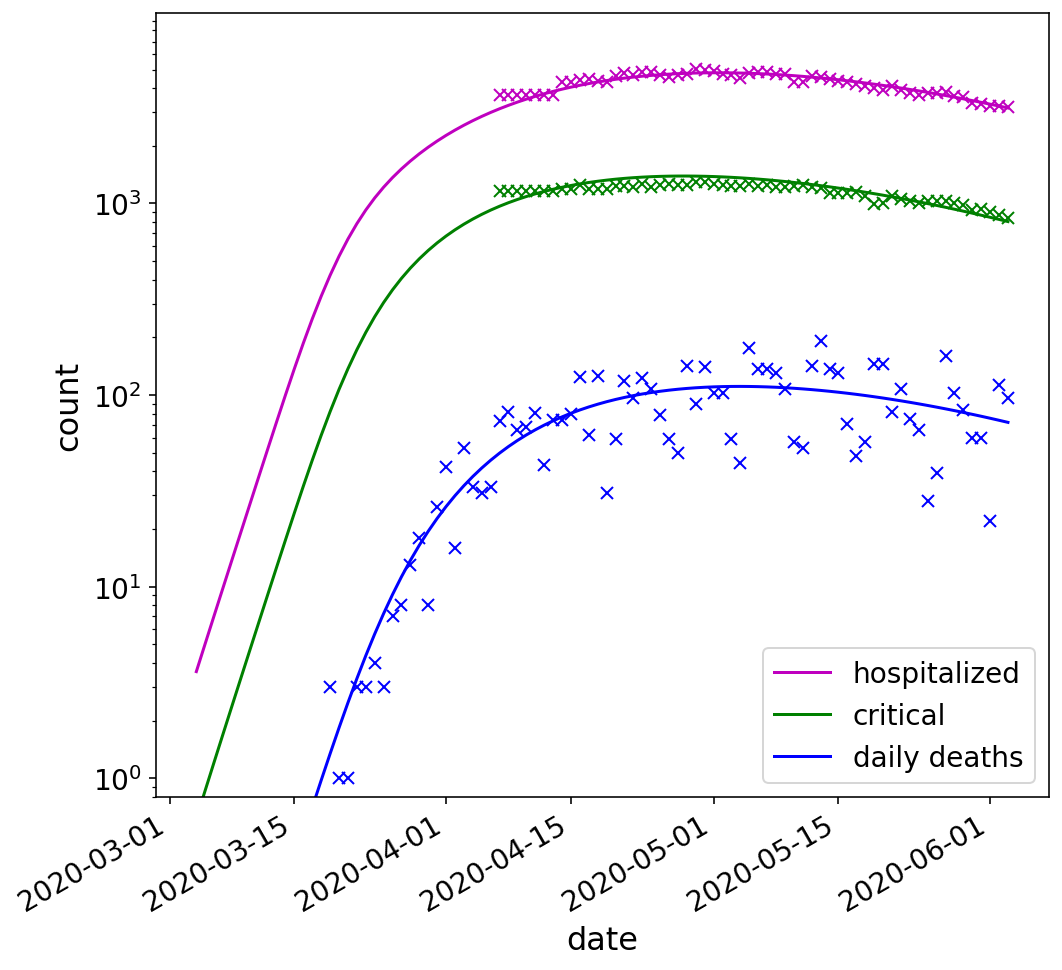

In [10]:
result = estimator.get_model_result(max_log_prob_values)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(result.index, result.hospitalized, '-m', label='hospitalized')
ax.plot(result.index, result.critical, '-g', label='critical')
ax.plot(result.index, result.all_dead_incr, '-b', label='daily deaths')
ax.plot(data.index, data.hospitalized, 'xm')
ax.plot(data.index, data.critical, 'xg')
ax.plot(data.index, data.all_dead_incr, 'xb')


ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)
fig.autofmt_xdate()

## Joint posterior probability distribution

We can study the pairwise-joint posterior probability distribution with [corner.py](https://github.com/dfm/corner.py/blob/master/corner/corner.py).
Below we plot the subset of sample parameters relevant to the parameterization of $R_t$.

Note that, while the above results appear to fit the data moderately well, obtaining a converged posterior (and likewise obtaining the global
best-fit model) requires a number of MCMC steps far beyond what is feasible for an example notebook.

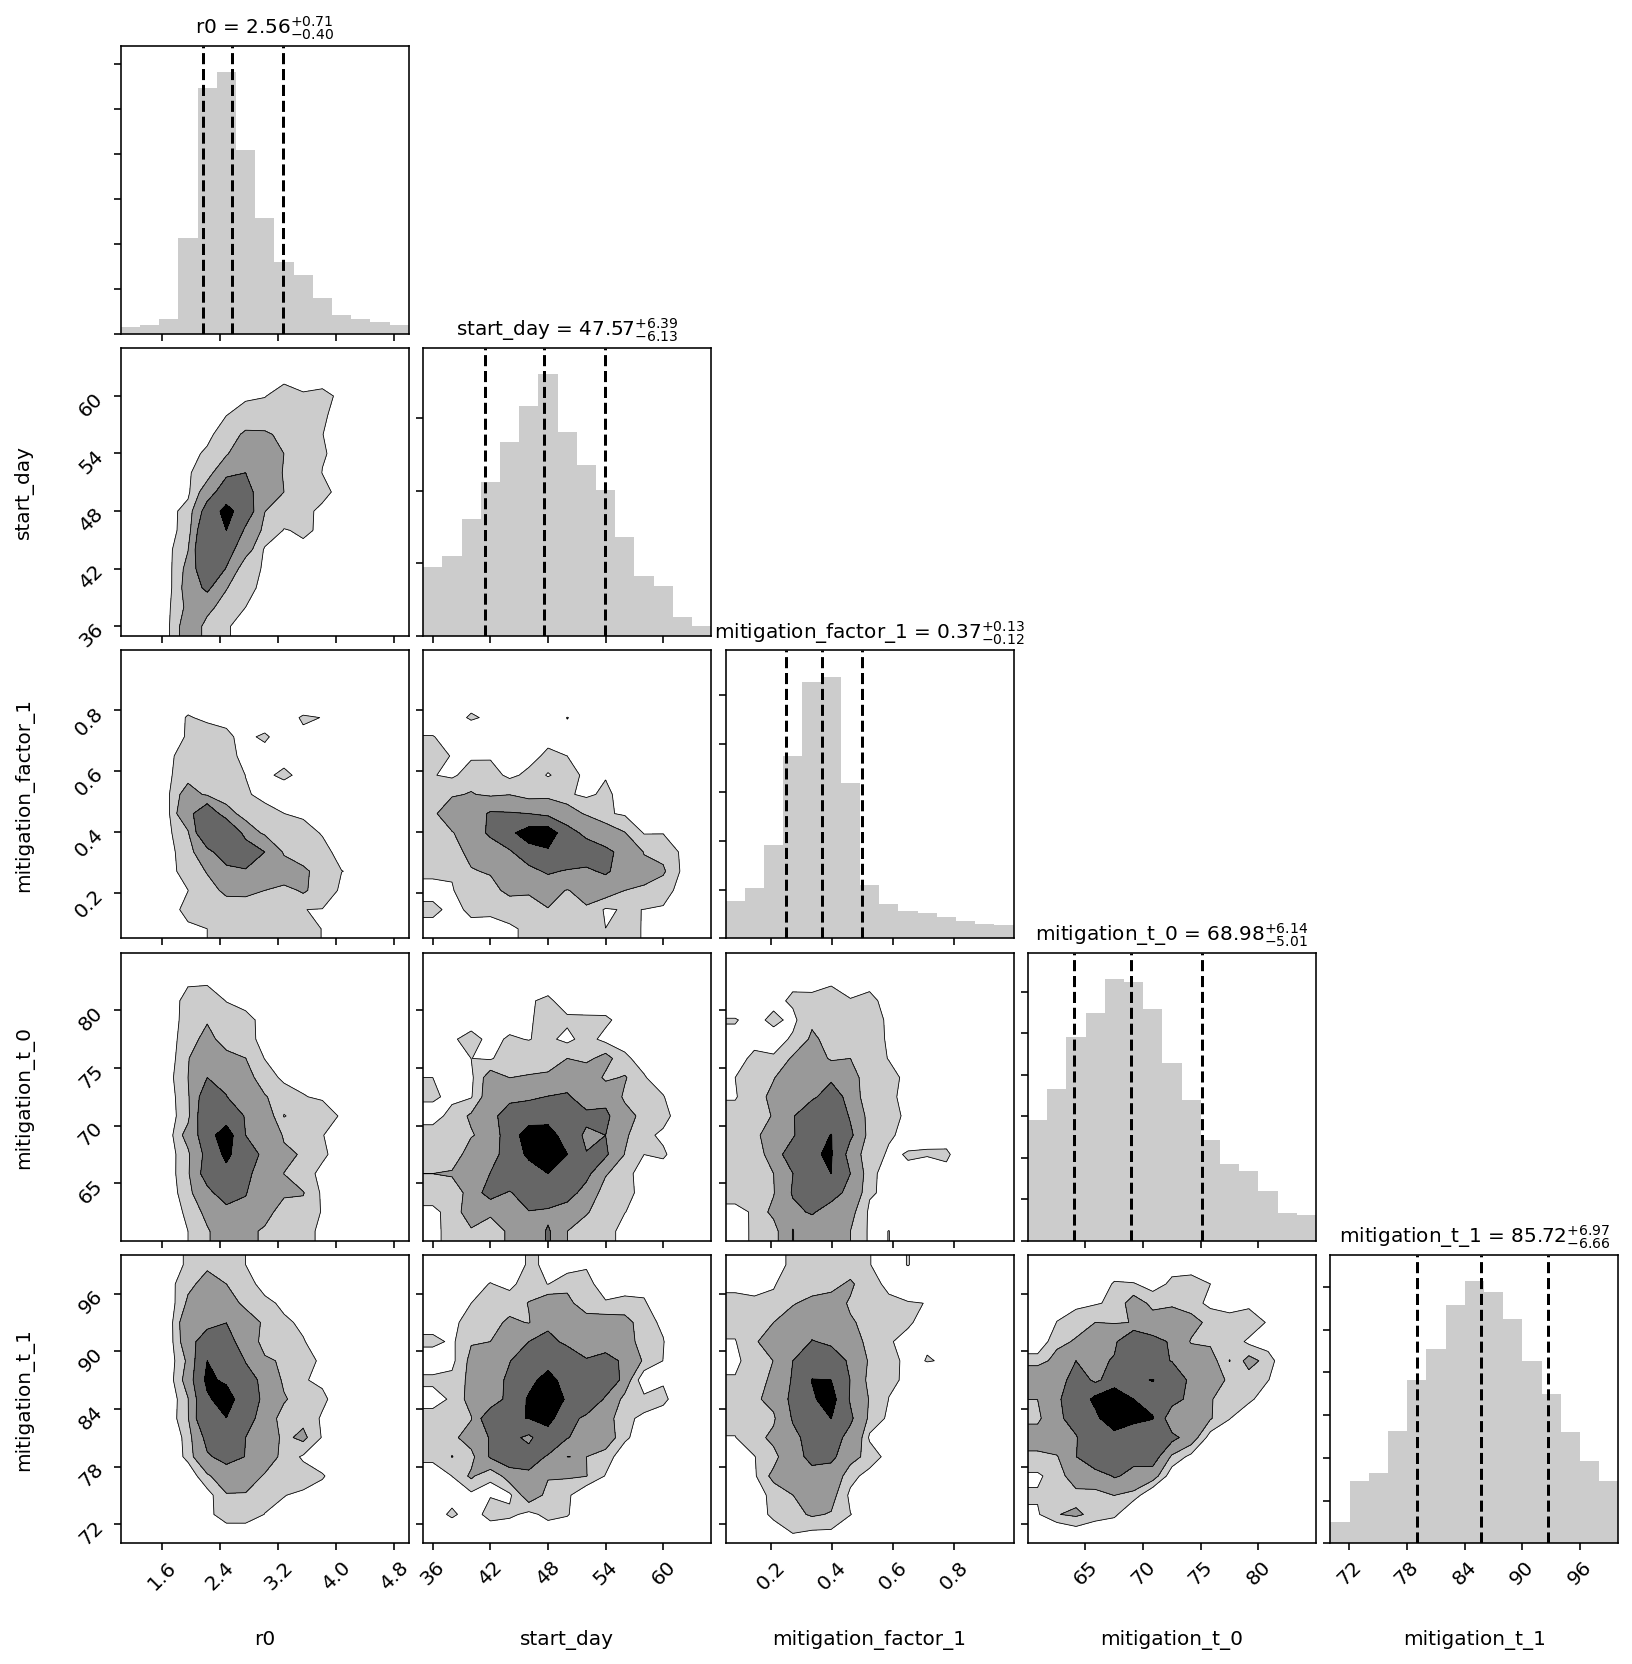

In [11]:
from corner import corner
import pandas as pd

cols = [par.name for par in sample_parameters]
samples_df = pd.DataFrame(flat_chain, columns=cols)
corner_params = ['r0', 'start_day', 'mitigation_factor_1', 'mitigation_t_0', 'mitigation_t_1']
fig = corner(
    samples_df.loc[:, corner_params],
    quantiles=[0.16, 0.5, 0.84],
    fill_contours=True, plot_contours=True,
    plot_density=False, plot_datapoints=False,
    bins=15,
    hist_kwargs=dict(histtype='stepfilled', alpha=.2),
    contour_kwargs=dict(linewidths=.4),
    show_titles=True, title_kwargs={"fontsize": 10},
)